In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Name: Aakash Thatte
# Roll number: 12041590

## References:
- https://towardsdatascience.com/autoencoders-from-vanilla-to-variational-6f5bb5537e4a


In [2]:
# Fetching the data
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/car.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/truck.npy

--2022-11-27 17:27:59--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.11.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118872512 (113M) [application/octet-stream]
Saving to: ‘airplane.npy’

airplane.npy        100%[===================>] 113.37M   162MB/s    in 0.7s    

2022-11-27 17:28:00 (162 MB/s) - ‘airplane.npy’ saved [118872512/118872512]

--2022-11-27 17:28:01--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bus.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 74.125.31.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130307152 (124M) [application/octet

In [4]:
# Importing all libraries
import sys
import os

import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
import graphviz 
import plotly

import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense, Lambda 
from tensorflow.keras.utils import plot_model 
from keras.models import Model 
from keras import Input 
from keras import backend as K 
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

In [ ]:
tf.__version__

In [5]:
# Loading the data
airplane=np.load('/kaggle/working/airplane.npy')
bicycle=np.load('/kaggle/working/bicycle.npy')
bus=np.load('/kaggle/working/bus.npy')
car=np.load('/kaggle/working/car.npy')
truck=np.load('/kaggle/working/truck.npy')

In [7]:
airplane.shape, airplane[0].shape

((151623, 784), (784,))

In [6]:
X_train=np.concatenate((airplane, bicycle, bus, car, truck), axis=0)
X_train.shape

(758476, 784)

In [8]:
mapp = {'airplane':0,'bicycle':1,'bus':2,'car':3,'truck':4}
inv_map = {v:k for k,v in mapp.items()}

In [9]:
# This comes in handy while using t-SNE
y_labels = []
for i in range(len(airplane)):
    y_labels.append(0)
for i in range(len(bicycle)):
    y_labels.append(1)
for i in range(len(bus)):
    y_labels.append(2)
for i in range(len(car)):
    y_labels.append(3)
for i in range(len(truck)):
    y_labels.append(4)

In [10]:
X_train_reshaped=X_train.reshape((X_train.shape[0],28,28,1))
X_train_reshaped.shape

(758476, 28, 28, 1)

In [11]:
len(y_labels)

758476

In [12]:
X_train_reshaped[0].shape

(28, 28, 1)

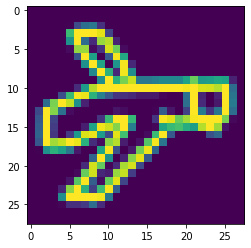

In [13]:
plt.imshow(X_train[0].reshape((28,28)));

### Train-Test split

In [14]:
np.random.shuffle(X_train_reshaped)
split_pc = 0.8 # 80% data for training
index = int(X_train_reshaped.shape[0]*split_pc)
training, test = X_train_reshaped[:index,:], X_train_reshaped[index:,:]

In [15]:
y_train, y_test = y_labels[:index], y_labels[index:]

In [16]:
len(training),len(y_train)

(606780, 606780)

In [17]:
training[0].shape

(28, 28, 1)

## Part I: Learning to generate doodles

#### Vanilla AE (architecture inspired by HoML)

In [18]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([28, 28, 1], input_shape=[28,28]),
    tf.keras.layers.Conv2D(
        16, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(
        32, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(
        64, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2)
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(
        32, kernel_size=3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]
    ),
    tf.keras.layers.Conv2DTranspose(
        16, kernel_size=3, strides=2, padding="same", activation="selu"
    ),
    tf.keras.layers.Conv2DTranspose(
        1, kernel_size=3, strides=2, padding="same", activation="sigmoid"
    ),
    tf.keras.layers.Reshape([28, 28,1])
])

2022-11-27 17:31:02.118071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 17:31:02.119214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 17:31:02.301192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 17:31:02.302242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 17:31:02.303099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [19]:
ae = tf.keras.models.Sequential([encoder, decoder])

ae.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

history = ae.fit(
    training, training, 
    epochs=10, # Running for 1 epoch just to test, I have already run for 15 epochs and will run for more later
#     validation_data=(X_val, X_val)
)

2022-11-27 17:31:25.533956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-27 17:31:28.027474: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18962/18962 [==============================] - 103s 5ms/step - loss: -670.3489 - accuracy: 0.5910
Epoch 2/10
18962/18962 [==============================] - 93s 5ms/step - loss: -671.4514 - accuracy: 0.6491
Epoch 3/10
18962/18962 [==============================] - 93s 5ms/step - loss: -671.5872 - accuracy: 0.6584
Epoch 4/10
18962/18962 [==============================] - 92s 5ms/step - loss: -671.6331 - accuracy: 0.6620
Epoch 5/10
18962/18962 [==============================] - 94s 5ms/step - loss: -671.6395 - accuracy: 0.6630
Epoch 6/10
18962/18962 [==============================] - 92s 5ms/step - loss: -671.6076 - accuracy: 0.6622
Epoch 7/10
18962/18962 [==============================] - 92s 5ms/step - loss: -671.5279 - accuracy: 0.6583
Epoch 8/10
18962/18962 [==============================] - 92s 5ms/step - loss: -671.3984 - accuracy: 0.6512
Epoch 9/10
18962/18962 [==============================] - 93s 5ms/step - loss: -671.2347 - accuracy: 0.6420
Epoch 10/10
18962/18962 [=============

In [ ]:
# Adding some more layers and trying to play with some shapes
# Though this does result in a very bad accuracy 😅
encoder_exp = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([28, 28, 1], input_shape=[28,28]),
    tf.keras.layers.Conv2D(
        16, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(
        32, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(
        64, kernel_size=3, padding="same", activation="selu"
    ),
    tf.keras.layers.MaxPool2D(pool_size=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200)
])

In [ ]:
decoder_exp = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(200,)),
    tf.keras.layers.Dense(576),
    tf.keras.layers.Reshape([3,3,64], input_shape=(576,)),
    
    tf.keras.layers.Conv2DTranspose(
        32, kernel_size=3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]
    ),
    tf.keras.layers.Conv2DTranspose(
        16, kernel_size=3, strides=2, padding="same", activation="selu"
    ),
    tf.keras.layers.Conv2DTranspose(
        1, kernel_size=3, strides=2, padding="same", activation="sigmoid"
    ),
    tf.keras.layers.Reshape([28, 28,1])
])

In [ ]:
encoder.input_shape, encoder.output_shape, decoder.input_shape, decoder.output_shape

In [ ]:
ae_exp = tf.keras.models.Sequential([encoder_exp, decoder_exp])

ae_exp.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

history_exp = ae_exp.fit(
    training, training, 
    epochs=10, # Running for 1 epoch just to test, I have already run for 15 epochs and will run for more later
#     validation_data=(X_val, X_val)
)

In [20]:
pred = ae.predict(test[0].reshape((1,28,28)))

In [21]:
pred.shape

(1, 28, 28, 1)

Text(0.5, 1.0, 'Actual image')

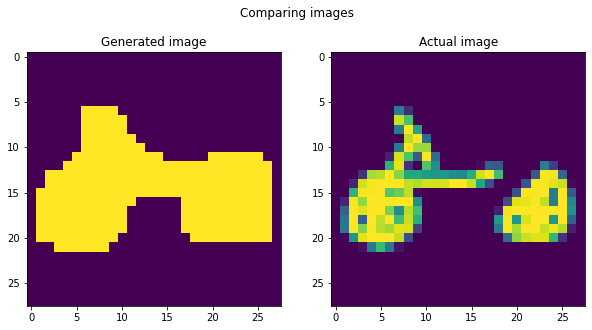

In [24]:
# plt.imshow(pred.reshape((28,28)))
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Comparing images')
axes[0].imshow(pred.reshape((28,28)))
axes[0].set_title("Generated image")
axes[1].imshow(test[0].reshape((28,28)))
axes[1].set_title("Actual image")

### Visualization using dimensionality reduction

- For this, I will use the encoder to get the latent representations, then map those to lower dimensions using t-SNE or UMAP etc and visualize them.

In [25]:
# # Getting the latent representations for the training data, maybe we can do so for random 500 images
# image_indices = np.random.choice(training.shape[0],100)
# airplane.shape[0]
# # images = []
# vectors = []
# labels = []
# for i in image_indices:
#     vectors.append(np.array(encoder(training[0].reshape((1,28,28)))).reshape((1,576)))
#     labels.append(y_train[i])
# encoder_exp(training[0].reshape((1,28,28))).shape, np.array(encoder(training[0].reshape((1,28,28)))).reshape((1,576)).shape
# # var_encoder(training[0].reshape((1,28,28)))
# # vectors = np.squeeze(np.array(vectors))
# vectors.shape

In [26]:
from sklearn.manifold import TSNE

In [ ]:
# tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
# tsne_vecs = tsne.fit_transform(vectors)
# tsne_vecs.shape
# print(len(labels))
# plt.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
# # We can see different clusters here
# # We do not have initial labels
# plt.legend()

# fig, ax = plt.subplots(figsize=(15, 15))
# ax.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
# #     plt.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
# for i in range(15):
#     a = np.random.randint(len(vectors))
#     ax.annotate(inv_map[labels[i]],tsne_vecs[i])

In [43]:
def do_tsne_encoder_exp(n):
    image_indices = np.random.choice(training.shape[0],n)
    vectors = []
    labels = []
    for i in image_indices:
        vectors.append(np.array(encoder_exp(training[i].reshape((1,28,28)))))
        labels.append(y_train[i])
    vectors = np.squeeze(np.array(vectors))
#     vectors.shape
    tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
    tsne_vecs = tsne.fit_transform(vectors)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
#     plt.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
    for i in range(25):
        a = np.random.randint(len(vectors))
        ax.annotate(inv_map[labels[i]],tsne_vecs[i])
        
def do_tsne_encoder(n):
    image_indices = np.random.choice(training.shape[0],n)
    vectors = []
    labels = []
    for i in image_indices:
        vectors.append(np.array(encoder(training[0].reshape((1,28,28)))).reshape((1,576)))
        labels.append(y_train[i])
    vectors = np.squeeze(np.array(vectors))
#     vectors.shape
    tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
    tsne_vecs = tsne.fit_transform(vectors)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
#     plt.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
    for i in range(25):
        a = np.random.randint(len(vectors))
        ax.annotate(inv_map[labels[i]],tsne_vecs[i])
        
def do_tsne_encoder_enh(n,p):
    image_indices = np.random.choice(training.shape[0],n)
    vectors = []
    labels = []
    for i in image_indices:
        vectors.append(np.array(encoder(training[0].reshape((1,28,28)))).reshape((1,576)))
        labels.append(y_train[i])
    vectors = np.squeeze(np.array(vectors))
#     vectors.shape
    tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3)
    tsne_vecs = tsne.fit_transform(vectors)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
#     plt.scatter(tsne_vecs[:,0],tsne_vecs[:,1],c=labels)
    for i in range(p):
        a = np.random.randint(len(vectors))
        ax.annotate(inv_map[labels[i]],tsne_vecs[i])
    plt.legend()

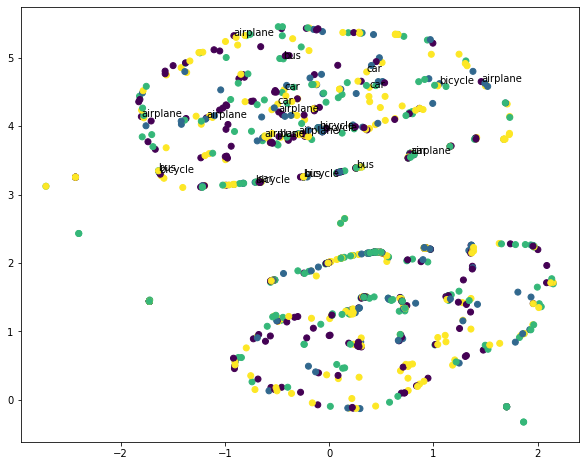

In [35]:
do_tsne_encoder(1000)
# We can see that though we trained for a small epochs
# the airplane, bicycle and bus are on the outer rings
# while other classes in inner clusters

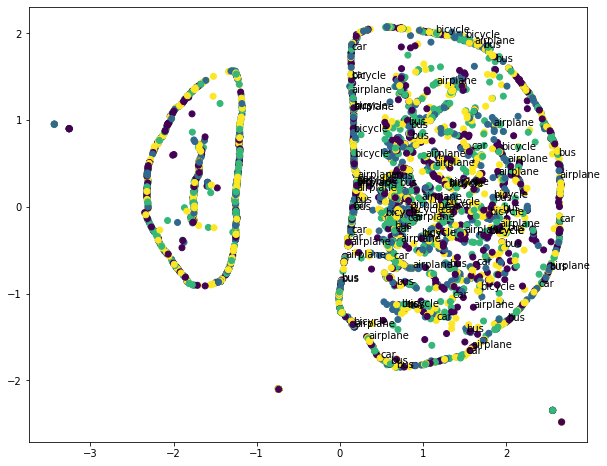

In [37]:
do_tsne_encoder_enh(5000,100)

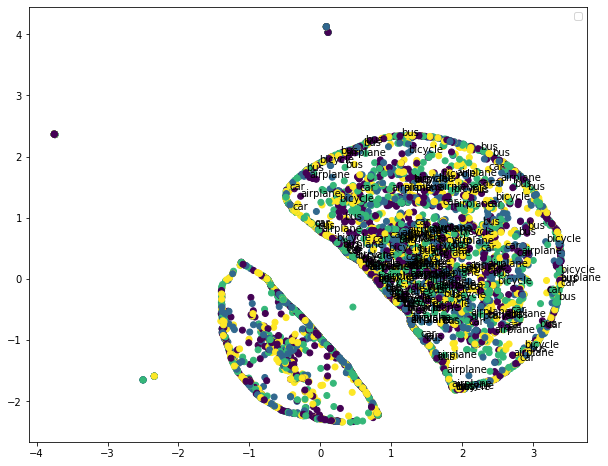

In [44]:
do_tsne_encoder_enh(6000,200)

In [ ]:
# tst = encoder_exp(training[0].reshape((1,28,28)))
# np.array(tst).shape
# vectors[0].shape,encoder.input_shape, encoder.output_shape, decoder.input_shape

------------------Need to analyse the above autoencoder---------------------

### Some important points
- Latent space values form an irregular, unbounded distribution, making it hard to sample random points.
- Latent representations of different image classes may vary in size(like some may form larger clusters, while some may form smaller ones), causing the model to generate some classes much more often than others.
- As we consider more and more dimensions, sampling a point to generate image is very likely to be far from any of the image classes.
- Unfortunately, the latent space learned by a vanilla autoencoder is not continuous. This means that there is no smooth transition in meaning between the points in this space. 

### Need for VAEs:
Three problems with using vanilla autoencoders as generative models: 
- We don’t know how to sample from an irregular, unbounded space.
- Some classes can be overrepresented in the latent space over others.
- The learned space is discontinuous, which makes it hard to find a point that would decode into a well-formed image.

- Variational autoencoder introduces randomness to the model and constraints the latent space.
- In VAEs we are essentially mapping an image to different points in the latent space given by a distribution.
- This way, we are trying to tell the model to generate the same image if a point comes from that distribution.

In [45]:
vanilla_encoder = tf.keras.models.clone_model(encoder)
encoder_inputs = tf.keras.layers.Input(shape=[28, 28])
z = vanilla_encoder(encoder_inputs)
z = tf.keras.layers.Flatten()(z)

In [46]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = K.random_normal(tf.shape(log_var))
        return mean + K.exp(log_var / 2) * epsilon

In [47]:
codings_mean = tf.keras.layers.Dense(576)(z)
codings_log_var = tf.keras.layers.Dense(576)(z)
codings = Sampling()([codings_mean, codings_log_var])

In [48]:
var_encoder = tf.keras.models.Model(
    inputs=[encoder_inputs], 
    outputs=[codings_mean, codings_log_var, codings]
)

In [49]:
vanilla_decoder = tf.keras.models.clone_model(decoder)

decoder_inputs = tf.keras.layers.Input(shape=[576])
x = tf.keras.layers.Reshape([3, 3, 64])(decoder_inputs)
decoder_outputs = vanilla_decoder(x)

var_decoder = tf.keras.models.Model(
    inputs=[decoder_inputs], 
    outputs=[decoder_outputs]
)

In [50]:
_, _, codings = var_encoder(encoder_inputs)
reconstructions = var_decoder(codings)
vae = tf.keras.models.Model(
    inputs=[encoder_inputs], 
    outputs=[reconstructions]
)

### Loss:
- `latent_loss` is the KL-divergence formula simplified in this special case in which the target distribution is a standard normal and both have no zero covariances.

In [51]:
latent_loss = -0.5 * \
    K.sum(1 + codings_log_var - K.exp(codings_log_var) - \
          K.square(codings_mean),
          axis=-1)
vae.add_loss(K.mean(latent_loss) / (28 * 28))
vae.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=["accuracy"]
)

In [52]:
history_vae = vae.fit(
    X_train_reshaped, X_train_reshaped, 
    epochs=2, 
    batch_size=128, 
#     validation_data=(X_val, X_val),
)

2022-11-27 18:10:38.665361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594645184 exceeds 10% of free system memory.
2022-11-27 18:10:39.361512: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594645184 exceeds 10% of free system memory.
2022-11-27 18:10:40.269670: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594645184 exceeds 10% of free system memory.
2022-11-27 18:10:41.144413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 594645184 exceeds 10% of free system memory.


Epoch 1/2
5926/5926 [==============================] - 50s 8ms/step - loss: nan - accuracy: 0.7172
Epoch 2/2
5926/5926 [==============================] - 49s 8ms/step - loss: nan - accuracy: 0.7172


In [53]:
pred_vae = vae.predict(X_train_reshaped[0].reshape((1,28,28)))

In [54]:
pred_vae.shape

(1, 28, 28, 1)

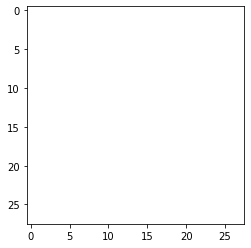

In [55]:
plt.imshow(pred_vae.reshape((28,28)))

## Part II: Creating mixture of doodles using interpolation

### Interpolation

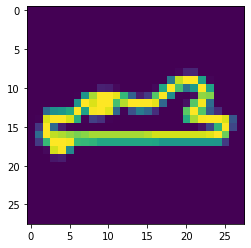

In [56]:
# Let us see what test[0] and test[300] look like
plt.imshow(test[300].reshape((28,28)))

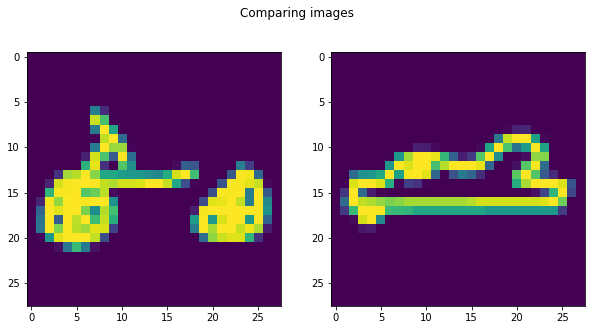

In [57]:
# import seaborn as sns
# These bicycle and car, let us try to interpolate them
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Comparing images')
axes[0].imshow(test[0].reshape((28,28)))
axes[1].imshow(test[300].reshape((28,28)))

In [58]:
def interpolate(image_1,image_2):
    i1 = encoder(image_1.reshape((1,28,28)))
    i2 = encoder(image_2.reshape((1,28,28)))
    
    # Now try different combinations of interpolating
    # say 0.1*a + 0.9*b or 0.3*a + 0.7*b etc
    tups = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    fig, axes = plt.subplots(4, 3, sharex=True, figsize=(14,7))
    fig.suptitle('Comparing image interpolations')
    t = 0
    for i in range(4):
        for j in range(3):
            try:
                a = tups[t]
                t+=1

                im = a*i1 + (1-a)*i2
                d_im = decoder(im)


                axes[i][j].imshow(np.array(d_im).reshape((28,28)))
                axes[i][j].set_title(f'{np.round(a,1)} times image_1 + {np.round(1-a,1)} times image_2')
            except:
                continue
                
def seq(image_1,image_2):
    i1 = encoder(image_1.reshape((1,28,28)))
    i2 = encoder(image_2.reshape((1,28,28)))
    
    # Now try different combinations of interpolating
    # say 0.1*a + 0.9*b or 0.3*a + 0.7*b etc
    tups = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    fig, axes = plt.subplots(1, 11, sharex=True, figsize=(16,2))
    fig.suptitle('Comparing image interpolations')
    for i in range(11):
        im = tups[i]*i1 + (1-tups[i])*i2
        d_im = decoder(im)
        axes[i].imshow(np.array(d_im).reshape((28,28)))

In [63]:
len(test)

151696

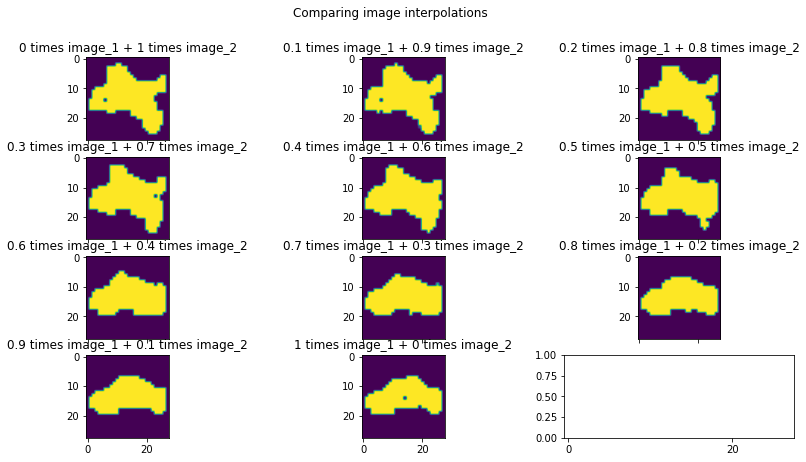

In [66]:
interpolate(test[10000],test[9000])
# These are all interpolations of generated images
# These are transitions from airplane to car
# In between, we get something like a scooter

##### Some previous results which I got
Interpolation from car to bicycle. We can see something like scooter in between.
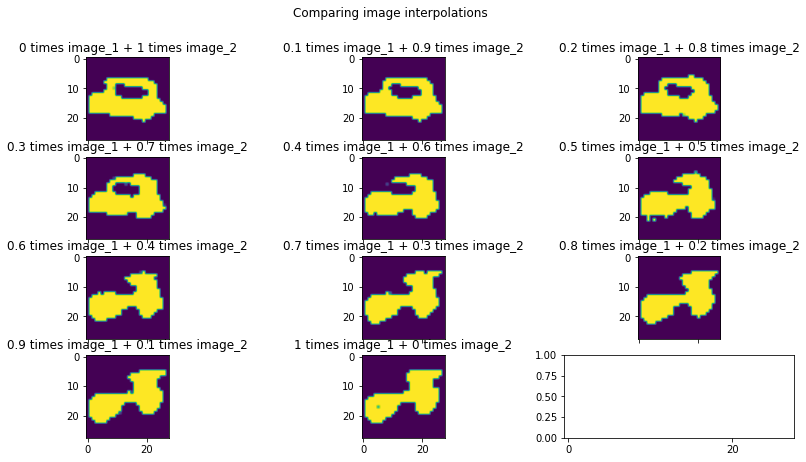

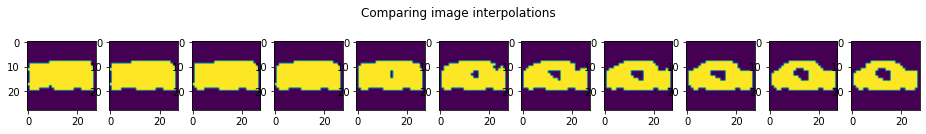

In [67]:
seq(test[250],test[3000])
# Bus to car

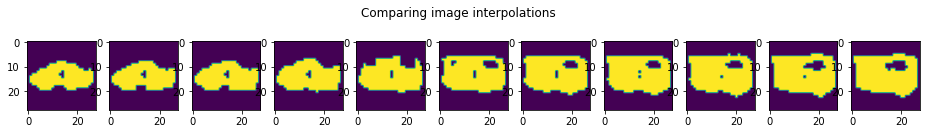

In [73]:
seq(test[14000],test[6000])
# We can see a car transiotioning into a bus like thing

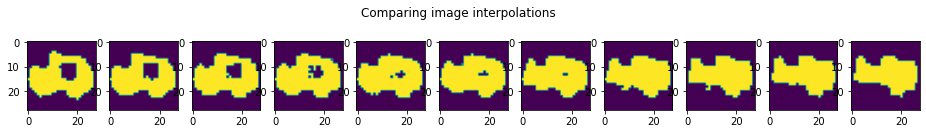

In [76]:
seq(test[9500],test[1000])
# A car transitioning into a plane

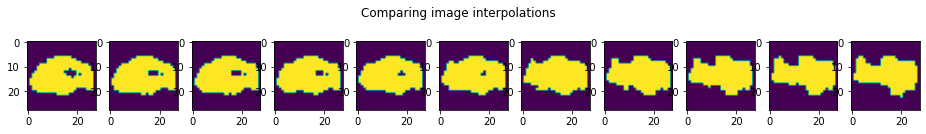

In [80]:
seq(test[9500],test[3700])
# A car transitioning into a plane

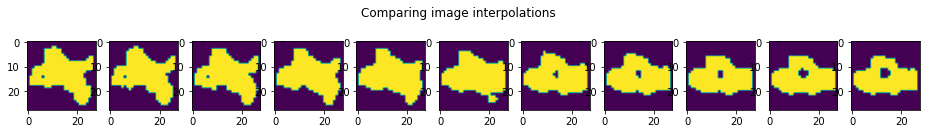

In [85]:
seq(test[180],test[9000])
# A plane transitioning into a car

## Part III: Interactive feature for users to generate doodles

In [ ]:
# Maybe we can take what percent of each type of class the user wants
# in the image. Then we can use the same interpolation strategy used above
# to create a new doodle based on that.
# Classes: car, bicycle, aircraft, bus, truck

In [86]:
def get_input():
    print("Enter all numbers in decimal and they should sum up to 1")
    a = float(input("What percent of car do you want?"))
    b = float(input("What percent of bicycle do you want?"))
    c = float(input("What percent of aircraft do you want?"))
    d = float(input("What percent of bus do you want?"))
    e = float(input("What percent of truck do you want?"))
    return [a,b,c,d,e]

In [87]:
# Select each from the training set randomly and then create doodle using 
# trained encoder and decoder (any of vanilla or variational)
def give_all():
    air = airplane[np.random.randint(airplane.shape[0])].reshape((28,28,1))
    bicy = bicycle[np.random.randint(bicycle.shape[0])].reshape((28,28,1))
    cr = car[np.random.randint(car.shape[0])].reshape((28,28,1))
    bs = bus[np.random.randint(bus.shape[0])].reshape((28,28,1))
    trck = truck[np.random.randint(truck.shape[0])].reshape((28,28,1))
    print(air.shape,bicy.shape,cr.shape,bs.shape,trck.shape)
    return cr,bicy,air,bs,trck
# print(air.shape,bicy.shape,cr.shape,bs.shape,trck.shape)

In [88]:
def gen_enc(lst):
    fnl =[]
    for l in lst:
        print(l.shape)
        fnl.append(encoder(l.reshape((1,28,28))))
#     i1 = encoder(im1.reshape((1,28,28)))
#     i2 = encoder(im2.reshape((1,28,28)))
#     i3 = encoder(im3.reshape((1,28,28)))
#     i4 = encoder(im4.reshape((1,28,28)))
#     i5 = encoder(im5.reshape((1,28,28)))
    return fnl

Enter all numbers in decimal and they should sum up to 1


What percent of car do you want? 0.9
What percent of bicycle do you want? 0
What percent of aircraft do you want? 0.1
What percent of bus do you want? 0
What percent of truck do you want? 0


(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


Text(0.5, 1.0, 'The generated image is as below:')

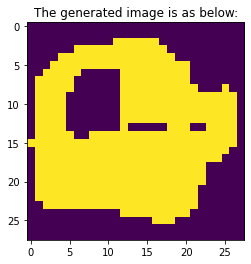

In [90]:
# Now we do everything here
a = 0.2
b = 0.3
c = 0.3
d = 0.1
e = 0.1
a,b,c,d,e = get_input()
carr,bicy,air,bs,trck = give_all()
print(carr.shape,bicy.shape,air.shape,bs.shape,trck.shape)
encodings = gen_enc(np.array([carr,bicy,air,bs,trck]))
resultant = None
for var, vec in zip([a,b,c,d,e],encodings):
    if resultant==None:
        resultant = var*vec
    if var!=0:
        resultant+= var*vec
decoded = decoder(resultant)
plt.imshow(np.array(decoded).reshape((28,28)))
plt.title("The generated image is as below:")

In [92]:
def do_everything():
    # Now we do everything here
    a = 0.2
    b = 0.3
    c = 0.3
    d = 0.1
    e = 0.1
    a,b,c,d,e = get_input()
    carr,bicy,air,bs,trck = give_all()
    print(carr.shape,bicy.shape,air.shape,bs.shape,trck.shape)
    encodings = gen_enc(np.array([carr,bicy,air,bs,trck]))
    resultant = None
    for var, vec in zip([a,b,c,d,e],encodings):
        if resultant==None:
            resultant = var*vec
        if var!=0:
            resultant+= var*vec
    decoded = decoder(resultant)
    plt.imshow(np.array(decoded).reshape((28,28)))
    plt.title("The generated image is as below:")

Enter all numbers in decimal and they should sum up to 1


What percent of car do you want? 0
What percent of bicycle do you want? 0.2
What percent of aircraft do you want? 0.5
What percent of bus do you want? 0.2
What percent of truck do you want? 0.1


(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


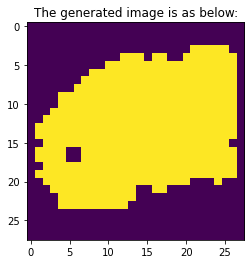

In [93]:
do_everything()

Enter all numbers in decimal and they should sum up to 1


What percent of car do you want? 0
What percent of bicycle do you want? 0
What percent of aircraft do you want? 0.99
What percent of bus do you want? 0
What percent of truck do you want? 0.01


(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


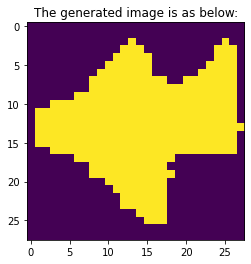

In [95]:
do_everything()

Enter all numbers in decimal and they should sum up to 1


What percent of car do you want? 0.5
What percent of bicycle do you want? 0
What percent of aircraft do you want? 0.5
What percent of bus do you want? 0
What percent of truck do you want? 0


(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1) (28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


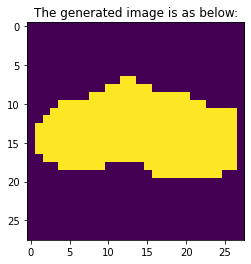

In [96]:
do_everything()
# Looks a little like car with wings!!